## Data Download and Libraries Import
In this example, we will perform a image segmentation using the fast.ai library and its example dataset.

In [1]:
pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 50.0MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
%matplotlib inline
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

Since the path is currently a list, a shortcut to extract the paths of the files is to divide by the name of the file

In [0]:
path_labels = path / 'labels'
path_images = path / 'images'

## Data Glance

In [0]:
filenames = get_image_files(path_images)

In [6]:
filenames[:5]

[PosixPath('/root/.fastai/data/camvid/images/0006R0_f02250.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f02610.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f01110.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f03150.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_01320.png')]

In [0]:
labelnames = get_image_files(path_labels)

In [8]:
labelnames[:5]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f02640_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08017_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08037_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_06420_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f00870_P.png')]

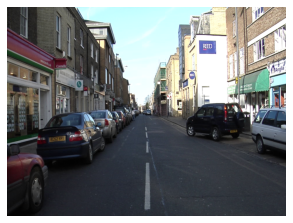

In [9]:
img = open_image(filenames[128])
img.show(figsize=(5,5))

In [0]:
#open_image(labelnames[128]).show(figsize=(5,5))

As we can see, the labels are not linked to its original images by number(128). Maybe they are related to each other by prefix and suffix

In [0]:
#helper function
get_y_fn = lambda x:path_labels/f'{x.stem}_P{x.suffix}'

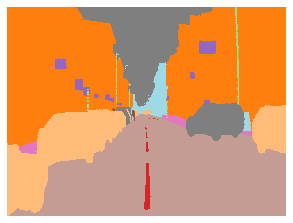

In [12]:
mask = open_mask(get_y_fn(filenames[128]))
mask.show(figsize=(5,5), alpha = 1)

In [13]:
source_size = np.array(mask.shape[1:])
source_size

array([720, 960])

In [14]:
mask.shape

torch.Size([1, 720, 960])

In [15]:
mask.data

tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         ...,
         [ 5,  5,  5,  ..., 17, 17, 17],
         [ 5,  5,  5,  ..., 17, 17, 17],
         [ 5,  5,  5,  ..., 17, 17, 17]]])

In [16]:
codes = np.loadtxt(path/'codes.txt',dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Create a data bunch

In [0]:
size = source_size // 2 ##integer division
bs = 4 #we do have enough GPU memory on Colab, luckily

In [0]:
src = (SegmentationItemList.from_folder(path_images)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

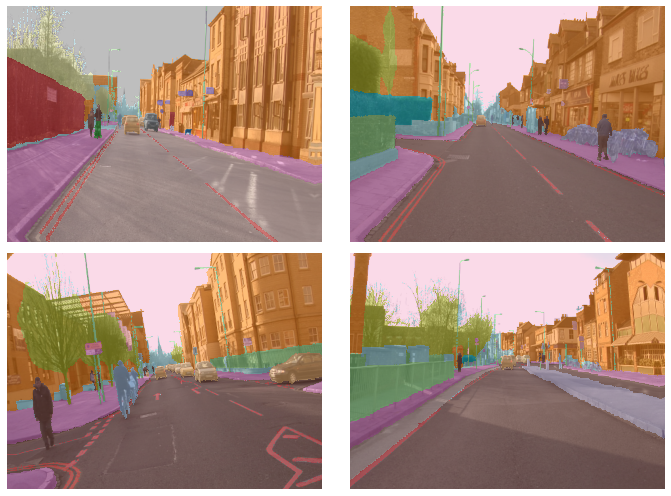

In [20]:
data.show_batch(2, figsize =(10, 7))

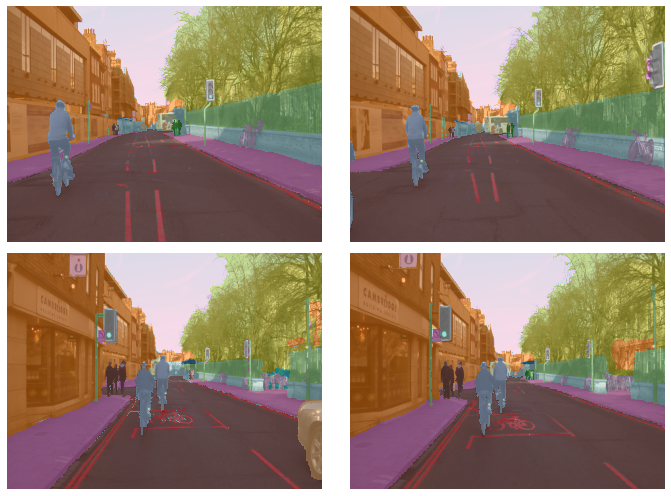

In [21]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Create a model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [0]:
wd  = 1e-2

In [0]:
learner = unet_learner(data, models.resnet34, metrics = metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


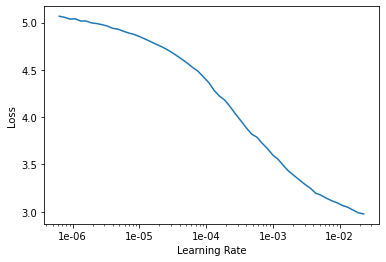

In [36]:
lr_find(learner)
learner.recorder.plot()

In [0]:
lr = 3e-3

In [41]:
learner.fit_one_cycle(10, slice(lr),pct_start=0.9)

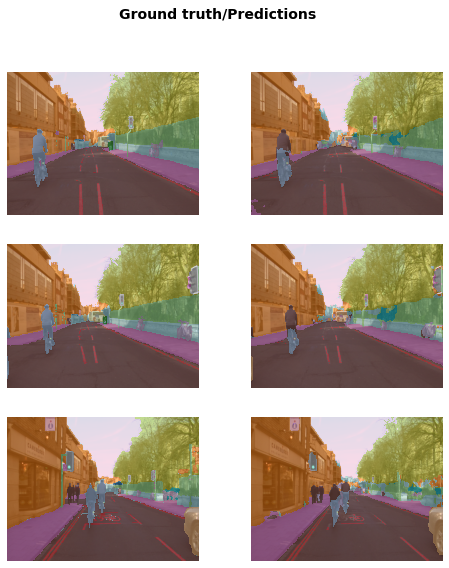

In [42]:
learner.save('stage-1')
learner.load('stage-1')
learner.show_results(rows=3,figsize=(8,9))

In [0]:
learner.unfreeze()

In [44]:
lrs = slice(lr/400, lr/4)
learner.fit_one_cycle(12, lrs, pct_start = 0.8)

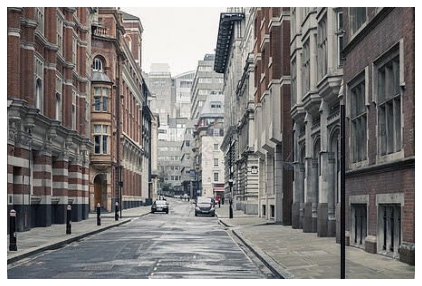

In [59]:
open_image('testpic.jpg').show(figsize=(14,5))

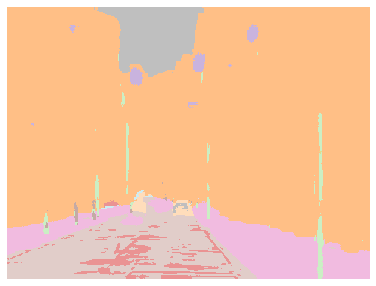

In [57]:
learner.predict(open_image('testpic.jpg'))[0].show(figsize=(14,5))

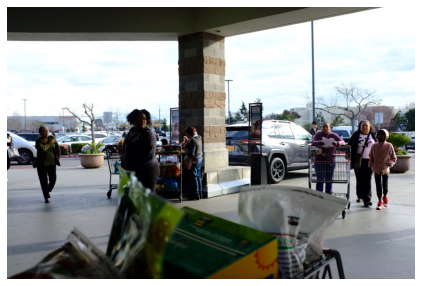

In [82]:
open_image('yinglu5.JPG').show(figsize=(14,5))

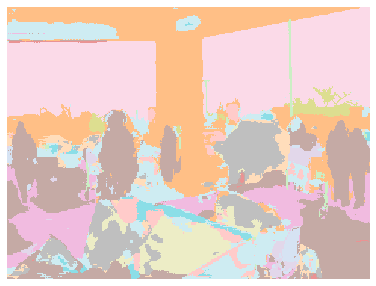

In [83]:
learner.predict(open_image('yinglu5.JPG'))[0].show(figsize=(14,5))

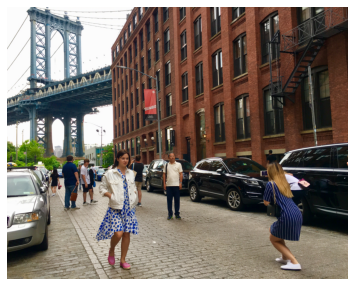

In [63]:
  open_image('testpic2.jpg').show(figsize=(14,5))

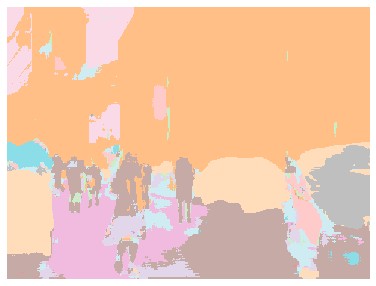

In [71]:
learner.predict(open_image('testpic2.jpg'))[0].show(figsize=(14,5))

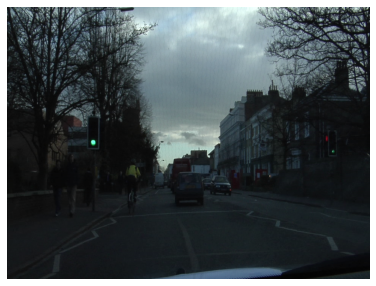

In [86]:
open_image(filenames[12]).show(figsize=(14,5))

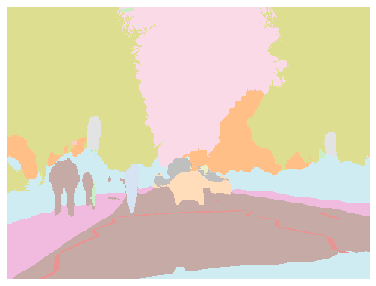

In [87]:
learner.predict(open_image(filenames[12]))[0].show(figsize=(14,5))

In [0]:
learner.save('stage-2')

## Go bigger????

In [92]:
learner.destroy()
size = source_size ##no longer source_size//2, going all in!!!!

this object has been destroyed


In [93]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 7074MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


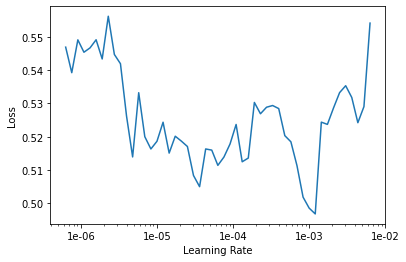

In [98]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 3e-3

In [100]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(3e-6,lr/10)

In [105]:
learn.fit_one_cycle(10, lrs)

In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

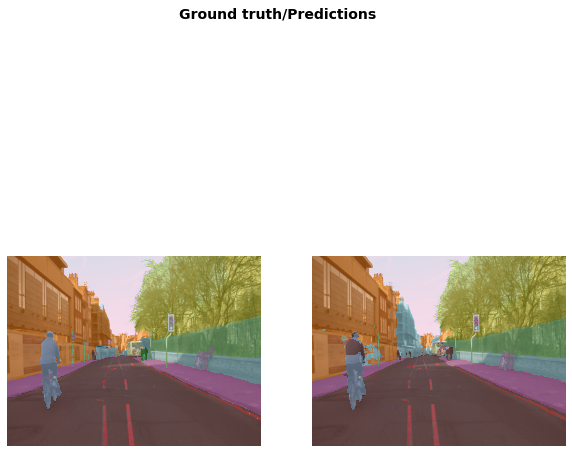

In [108]:
learn.show_results(rows=3, figsize=(10,10))

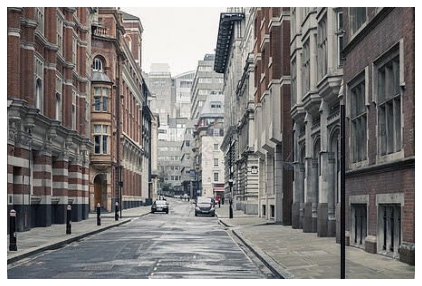

In [109]:
open_image('testpic.jpg').show(figsize=(14,5))

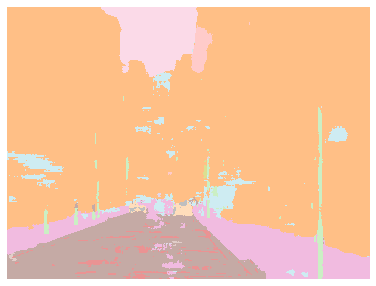

In [112]:
learn.predict(open_image('testpic.jpg'))[0].show(figsize=(14,5))

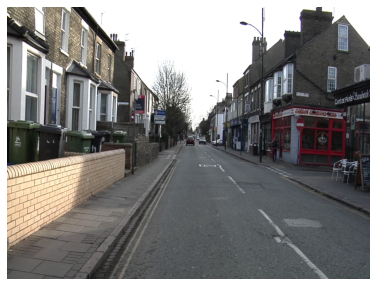

In [132]:
open_image(filenames[11]).show(figsize=(14,5))

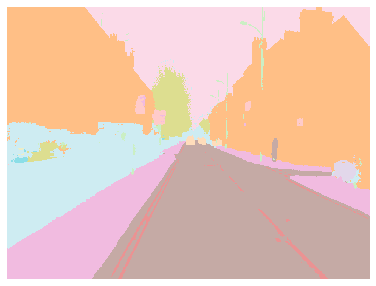

In [133]:
learn.predict(open_image(filenames[11]))[0].show(figsize=(14,5))

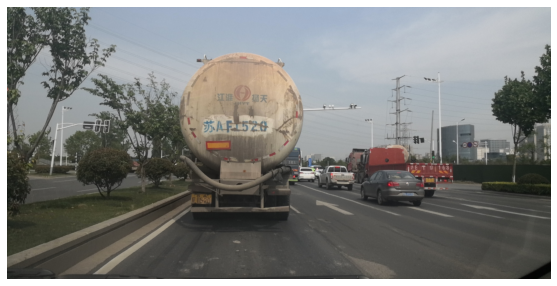

In [116]:
open_image('mama.jpg').show(figsize=(14,5))

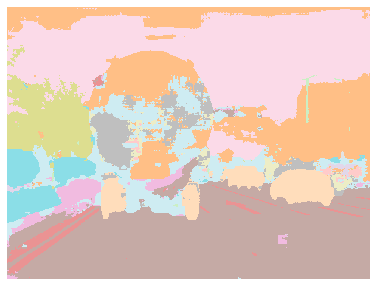

In [119]:
learn.predict(open_image('mama.jpg'))[0].show(figsize=(14,5))

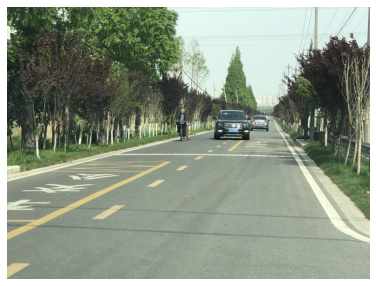

In [145]:
open_image('mama7.jpg').show(figsize=(14,5))

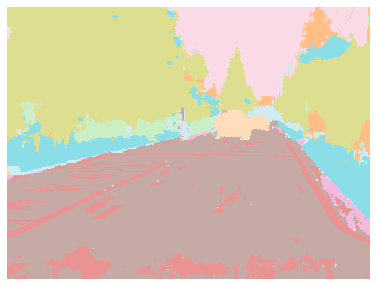

In [146]:
learn.predict(open_image('mama7.jpg'))[0].show(figsize=(14,5))

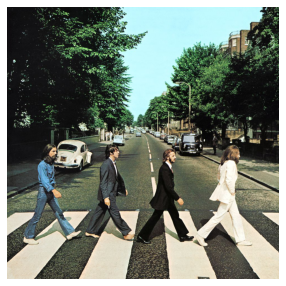

In [122]:
open_image('test3.jpg').show(figsize=(14,5))

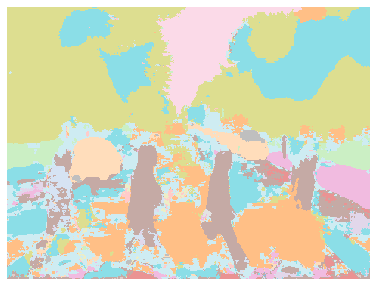

In [123]:
learn.predict(open_image('test3.jpg'))[0].show(figsize=(14,5))

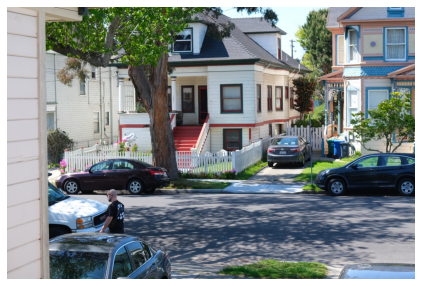

In [138]:
open_image('yinglu3.JPG').show(figsize=(14,5))

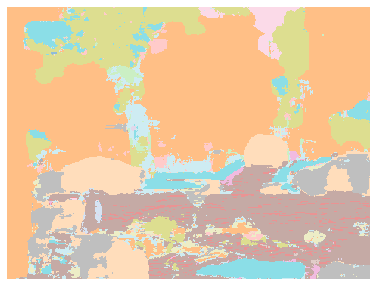

In [140]:
learn.predict(open_image('yinglu3.JPG'))[0].show(figsize=(14,5))